In [2]:
# Import der notwendigen Bibliotheken:


In [3]:
import pypsa
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt


C:\Users\sarah\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\sarah\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\sarah\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [4]:
# PyPSA-Netz & Snapshots definieren:

In [5]:
snapshots = pd.date_range("2019-01-01", periods=12, freq="MS")
n = pypsa.Network()
n.set_snapshots(snapshots)
print(snapshots)


DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', freq='MS')


In [6]:
# Dummy Netz aufsetzen:

In [7]:
n.add("Carrier", "dummy")
n.add("Bus", "bus0", carrier="dummy")
n.add("Generator", "dummy_gen", bus="bus0",
      p_nom=1.0, p_min_pu=0.0, p_max_pu=0.0,
      marginal_cost=1e-6)  # <- kleine Kosten, damit PyPSA eine Objective bauen kann


Index(['dummy_gen'], dtype='object')

In [8]:
# Pflanzendaten, parameter einlesen:

In [9]:
df_crops_parameter = pd.read_excel("../Input/Finale_Pflanzendaten_Mappe.xlsx", sheet_name="crops_parameter").set_index("crop")
df_crops_yield = pd.read_excel("../Input/Finale_Pflanzendaten_Mappe.xlsx", sheet_name="crops_yield").set_index("snapshot")
df_person_demand = pd.read_excel("../Input/Finale_Pflanzendaten_Mappe.xlsx", sheet_name="person_demand").set_index("person")

print(df_crops_parameter.head())   # erste 5 Pflanzen-Parameter
print(df_crops_yield.head())       # erste 5 Monats-Erträge
print(df_person_demand.head())     # erste 5 Zeilen Nachfrage



          energy_kwh_per_m2_month  light_kwh_per_m2_month  y_cycle_kg_m2  \
crop                                                                       
Tomate                     225.00                   144.0      53.951923   
Paprika                     58.00                    37.0      18.500000   
Gurke                      118.75                    75.0      40.675714   
Salat                       17.60                    11.0       4.713333   
Zucchini                    15.00                     9.0       6.195385   

          T_days  W_max  kcal_per_kg  prot_g_per_kg  carb_g_per_kg  \
crop                                                                 
Tomate        90      7          190            7.0           35.0   
Paprika      120      9          430           13.0           64.0   
Gurke        120      5          140            6.0           18.0   
Salat         30      6          140           12.0           11.0   
Zucchini      90      7          190           

In [10]:
crops = list(df_crops_yield.columns)                        # crops python-liste erstellen aus tabelle

yield_per_area = xr.DataArray(df_crops_yield.values,        #xArray erstellen
                  coords= {"snapshot": snapshots, "crop": df_crops_yield.columns},
                  dims=("snapshot", "crop"))
print(crops)
print(yield_per_area)


['Tomate', 'Paprika', 'Gurke', 'Salat', 'Zucchini', 'Kohlrabi', 'Spinat', 'Kartoffel', 'Erdbeere', 'Sojabohne', 'Linsen', 'Kichererbsen', 'Bohnen', 'Mangold', 'Radisschen', 'Rote Bete', 'Suesskartoffel']
<xarray.DataArray (snapshot: 12, crop: 17)> Size: 2kB
array([[ 0. ,  0. ,  0. ,  4.7,  0. ,  0. ,  2.1,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  5. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  4.7,  0. ,  0. ,  2.1,  0. ,  0. ,  0. ,  0. ,
         0. ,  2.9,  8.3,  5. ,  7.6,  0. ],
       [54. ,  0. ,  0. ,  4.7,  6.2,  4.8,  2.1,  6.5,  5.8,  1. ,  0.3,
         0.4,  0. ,  0. ,  5. ,  0. ,  0. ],
       [ 0. , 18.5, 40. ,  4.7,  0. ,  0. ,  2.1,  0. ,  0. ,  0. ,  0. ,
         0. ,  2.9,  8.3,  5. ,  7.6, 10. ],
       [ 0. ,  0. ,  0. ,  4.7,  0. ,  0. ,  2.1,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  5. ,  0. ,  0. ],
       [54. ,  0. ,  0. ,  4.7,  6.2,  4.8,  2.1,  6.5,  5.8,  1. ,  0.3,
         0.4,  2.9,  8.3,  5. ,  7.6,  0. ],
       [ 0. ,  0. ,  0. ,  4

In [11]:
# Pflanzen wachstumsphasen zuordnen damit die Fläche über die gesamte Wachstumsdauer aktiv ist: (30 Tage = 1 Monat)

In [12]:
growth_months = (( df_crops_parameter.loc[crops, "T_days"] / 30)        # df_crops_parameter hat Index 'crops' und Spalte 'T_days'
                 .round()                                               # auf Monat umrechnen
                 .clip(lower=1)                                         # sollte eh 1/2/3/4 sein
                 .astype(int)
                 .to_dict()                                              # { "Tomate": 3, ... }
                )

print(growth_months)

{'Tomate': 3, 'Paprika': 4, 'Gurke': 4, 'Salat': 1, 'Zucchini': 3, 'Kohlrabi': 3, 'Spinat': 1, 'Kartoffel': 3, 'Erdbeere': 3, 'Sojabohne': 3, 'Linsen': 3, 'Kichererbsen': 3, 'Bohnen': 2, 'Mangold': 2, 'Radisschen': 1, 'Rote Bete': 2, 'Suesskartoffel': 4}


In [13]:
#Parameter der Fläche definieren:

In [14]:
Amax_total = 120  # m²

In [15]:
# Ziel - Personenanzahl wählen

In [16]:
person = 1
row = df_person_demand.loc[person]  # enthält: kcal, prot_g, carb_g, sugar_g, fiber_g, fat_g (pro TAG)
print(df_person_demand.loc[person])

kcal       2250
prot_g       55
carb_g      260
sugar_g      25
fiber_g      30
fat_g        75
Name: 1, dtype: int64


In [17]:
#Lager Start Wert vorgeben:

In [18]:
# Anfangs-Lager: Faktor × Monatsbedarf (z. B. 1.0 = ein Monatsbedarf als Startlager ist gedeckt)
S_init_factor = 1.0

In [19]:
# Linopy-Modell erzeugen:

In [20]:
m = n.optimize.create_model()

In [21]:
#Entscheidungsvariabeln einfügen:

In [22]:
build  = m.add_variables(binary=True, name="build",  coords=[("crop", crops)])
active = m.add_variables(binary=True, name="active", coords=[("snapshot", n.snapshots), ("crop", crops)])
area   = m.add_variables(lower=0.0,   name="area",   coords=[("snapshot", n.snapshots), ("crop", crops)])


In [23]:
# Model-Bedingungen als Constraints hinzufügen:

In [24]:
m.add_constraints(active <= build, name="active<=build")
m.add_constraints(area   <= 1e3 * active, name="area_cap_if_active")  # "Big-M  Methode"
m.add_constraints(area.sum("crop") <= Amax_total, name="total_area_cap")  # Σ Fläche ≤ 100 m²

Constraint `total_area_cap` [snapshot: 12]:
-------------------------------------------
[2019-01-01 00:00:00]: +1 area[2019-01-01 00:00:00, Tomate] + 1 area[2019-01-01 00:00:00, Paprika] + 1 area[2019-01-01 00:00:00, Gurke] ... +1 area[2019-01-01 00:00:00, Radisschen] + 1 area[2019-01-01 00:00:00, Rote Bete] + 1 area[2019-01-01 00:00:00, Suesskartoffel] ≤ 120.0
[2019-02-01 00:00:00]: +1 area[2019-02-01 00:00:00, Tomate] + 1 area[2019-02-01 00:00:00, Paprika] + 1 area[2019-02-01 00:00:00, Gurke] ... +1 area[2019-02-01 00:00:00, Radisschen] + 1 area[2019-02-01 00:00:00, Rote Bete] + 1 area[2019-02-01 00:00:00, Suesskartoffel] ≤ 120.0
[2019-03-01 00:00:00]: +1 area[2019-03-01 00:00:00, Tomate] + 1 area[2019-03-01 00:00:00, Paprika] + 1 area[2019-03-01 00:00:00, Gurke] ... +1 area[2019-03-01 00:00:00, Radisschen] + 1 area[2019-03-01 00:00:00, Rote Bete] + 1 area[2019-03-01 00:00:00, Suesskartoffel] ≤ 120.0
[2019-04-01 00:00:00]: +1 area[2019-04-01 00:00:00, Tomate] + 1 area[2019-04-01 00:0

In [25]:
# Grow Cycle Constraint

In [26]:
# für jede crop c und jeden Erntemonat h (da wo yield_per_aera > 0 ist und k = 1,...,L-1 erzwingen wir area_h-k >= area_h:
# # Wenn im März geerntet wird, dann muss im Februar und Januar mindestens dieselbe Fläche unter Tomaten stehen wie im März.
# Gleiches gilt für jede weitere Ernte (Jun: Apr+Mai ≥ Jun; Sep: Jul+Aug ≥ Sep; …)
# → Das bildet eine durchgehende Anbauphase von L Monaten vor der Ernte ab (Wachstum)

counter = 0                                  # counter ist ein Zähler, der bei jedem Durchlauf von h,k,c um 1 erhöht wird
snap_list = list(n.snapshots.values)        # baue eine Python liste aus den Snapshots damit man im Loop an positionen 0,1,2,... herankommen kann
for c in crops:                             # nimm jedes element aus der liste crops und speicher es als variable c
    L = growth_months[c]                                                # weist der variable L von crop c den Wert aus dem growth_months-dict zu
    y = yield_per_area.sel(crop=c).to_pandas().values                   # yield_per_area ist ein xarray-Datensatz mit Index 'snapshot' und Spalten 'crop'
    harvest_month_idx = [i for i, v in enumerate(y) if v > 0]           # .sel(crop=c) filtert das Array nach aktuellen crop c. Ergebnis: Zeitreihe über Monate
                                                                        # mit Ernteertrag pro m2. .to_pandas() wandelt das Array in eine Liste. und . values holt die Zahlen aus der Series und macht daraus ein Numpy Array - einfacher Zahlenvektor

#  harvest_month_idx = [i for i, v in enumerate(y) if v > 1e-12]:
    # y ist ein Array und enthält die Ernteerträge pro Monat (0,0,12,..) für jede Pflanze
    # enumerate(y) macht daraus Paare (Index, Wert) wie (0,0) (1,0), (2,12)
    # i ist dann die Monatsnummer (0-11) und v der Erntewert von diesem Monat
    # if v > 0 sagt: Nur die Monate, wo es wirklich Ertrag gibt, sollen berücksichtigt werden
    # gibt mir am ende die monate mit ernteerträgem aus!
    for h in harvest_month_idx:       # harvest_month_idx sind Monatspositionen (0=Jan,...) in denen es für c Ertrag >0 gibt - wir gehen jeden monat h durch
        for k in range(1, L):         # k ist ne Folge von Zahlen von range(start,stop) 1 bis L-1 weil stop bei range nicht mitgezählt wird
                                      # gibt anbauzeit vor erntemonat
                                      # an k = 0 wäre Erntemonat, k=1 = 1 Monat vor ernte: alle Monate vor der Ernte, die zur Wachstumszeit
                                      # gehören
            if h - k < 0:             # h ist der Index des Erntemonats (Bsp: Ernter im Januar: h=0), k die Anzahl der Monate vor der Ernte
                continue              # wenn wir im Januar ernte haben und k zurück gehen würden wären wir im Jahr davor - Jahresmodel:
                                      # deshalb = continue bedeutet
            counter += 1              # überspring das! verhindert in negatigve Monate zu rutschen
                                      # "Wenn die Pflanze im Januar geerntet wird, ignoriere die Bedingung, dass sie im Vorjahr angebaut sein
                                      # muss."

            m.add_constraints(        # Nebenbedingungen hinzufügen
                area.sel(snapshot=snap_list[h-k], crop=c) >= area.sel(snapshot=snap_list[h], crop=c), name=f"grow_cycle_area_{c}_{h}_minus_{k}_{counter}")
            # area.sel(snapshot=snap_list[h-k], crop=c): Die Anbaufläche der Pflanze c im Monat h-k (also die Monate vor der Ernte)
            # area.sel(snapshot=snap_list[h], crop=c):  Die Anbaufläche der Pflanze im Erntemonat h
            # Constraint-Bedingung: area[h-k] >= area[h]: Die Anbaufläche in der Anbauzeit, muss mindestens so groß sein wie die Fläche im
            # Erntemonat
            # Damit jede Nebenbedingung einen eindeutigen Namen hat, wird sie mit grow_cycle_area_{c}_{h}_minus_{k} bezeichnet. Beispiel:
            # grow_cycle_area_Tomate_5_minus_2 heißt: Tomate, Erntemonat Index 5, Rückblick 2 Monate

In [27]:
# lineare Ausdrücke (symbolische Rechnungen), die aus meinen Variablen entstehen. Sie bekommen erst Zahlenwerte, wenn der Solver area gelöst hat.

In [28]:
#  Kg pro Ernte mit der optimierten Fläche je crop
harvest_expr = yield_per_area * area

In [29]:
# Nährstoffproduktion je Ernte

In [30]:
kcal_per_kg  = xr.DataArray(df_crops_parameter["kcal_per_kg"],  dims=["crop"], coords={"crop": df_crops_parameter.index})
prot_per_kg  = xr.DataArray(df_crops_parameter["prot_g_per_kg"], dims=["crop"], coords={"crop": df_crops_parameter.index})
carb_per_kg  = xr.DataArray(df_crops_parameter["carb_g_per_kg"],   dims=["crop"], coords={"crop": df_crops_parameter.index})
sugar_per_kg = xr.DataArray(df_crops_parameter["sugar_g_per_kg"],  dims=["crop"], coords={"crop": df_crops_parameter.index})
fiber_per_kg = xr.DataArray(df_crops_parameter["fiber_g_per_kg"],  dims=["crop"], coords={"crop": df_crops_parameter.index})
fat_per_kg   = xr.DataArray(df_crops_parameter["fat_g_per_kg"],    dims=["crop"], coords={"crop": df_crops_parameter.index})

prod_kcal_expr  = (harvest_expr * kcal_per_kg ).sum("crop")
prod_prot_expr  = (harvest_expr * prot_per_kg ).sum("crop")
prod_carb_expr  = (harvest_expr * carb_per_kg ).sum("crop")
prod_sugar_expr = (harvest_expr * sugar_per_kg).sum("crop")
prod_fiber_expr = (harvest_expr * fiber_per_kg).sum("crop")
prod_fat_expr   = (harvest_expr * fat_per_kg)  .sum("crop")



In [31]:
#Lager dynamik aufstellen:

In [32]:
def add_stock(m, name, prod_expr, demand, snapshots, S_init_factor=1.0):
    stock = m.add_variables(lower=0.0, name=name, coords=[("snapshot", snapshots)])
    S_init = float(S_init_factor * demand.isel(snapshot=0))

    # Bilanzgleichung für den ersten Monat t=0
    m.add_constraints(stock.isel(snapshot=0) ==
                      prod_expr.isel(snapshot=0) - demand.isel(snapshot=0) + S_init,
                      name=f"{name}_balance_t0")
    # S0 = Prod_0 - Bedarf_0 + S_init

    # Dynamik für alle Folgemonate
    # t=1..T-1
    m.add_constraints(
        stock.isel(snapshot=slice(1, None)) ==
        stock.isel(snapshot=slice(0, -1)) +
        prod_expr.isel(snapshot=slice(1, None)) -
        demand.isel(snapshot=slice(1, None)),
        name=f"{name}_balance_dyn"
    )
    # S_t = S_{t-1} + Prod_t - Bedarf_t -> damit wird zeitliche Deckung erzwungen
    return stock




In [33]:
 # Lager für alle Nährstoffe: stock_kcal, ...

In [34]:
days_per_month = 30

demand_kcal  = xr.DataArray([row["kcal"]     * days_per_month]*len(n.snapshots), coords={"snapshot": n.snapshots}, dims=["snapshot"])
demand_prot  = xr.DataArray([row["prot_g"]   * days_per_month]*len(n.snapshots), coords={"snapshot": n.snapshots}, dims=["snapshot"])
demand_carb  = xr.DataArray([row["carb_g"]   * days_per_month]*len(n.snapshots), coords={"snapshot": n.snapshots}, dims=["snapshot"])
demand_sugar = xr.DataArray([row["sugar_g"]  * days_per_month]*len(n.snapshots), coords={"snapshot": n.snapshots}, dims=["snapshot"])
demand_fiber = xr.DataArray([row["fiber_g"]  * days_per_month]*len(n.snapshots), coords={"snapshot": n.snapshots}, dims=["snapshot"])
demand_fat   = xr.DataArray([row["fat_g"]    * days_per_month]*len(n.snapshots), coords={"snapshot": n.snapshots}, dims=["snapshot"])


# Lager-Funktion die oben definiert wurde aufrufen:
stock_kcal  = add_stock(m, "stock_kcal",  prod_kcal_expr,  demand_kcal,  n.snapshots, S_init_factor)
stock_prot  = add_stock(m, "stock_prot",  prod_prot_expr,  demand_prot,  n.snapshots, S_init_factor)
stock_carb  = add_stock(m, "stock_carb",  prod_carb_expr,  demand_carb,  n.snapshots, S_init_factor)
stock_sugar = add_stock(m, "stock_sugar", prod_sugar_expr, demand_sugar, n.snapshots, S_init_factor)
stock_fiber = add_stock(m, "stock_fiber", prod_fiber_expr, demand_fiber, n.snapshots, S_init_factor)
stock_fat   = add_stock(m, "stock_fat",   prod_fat_expr,   demand_fat,   n.snapshots, S_init_factor)

print(demand_kcal.to_pandas().head())
print(demand_prot.to_pandas().head())
print(demand_carb.to_pandas().head())
print(demand_sugar.to_pandas().head())
print(demand_fiber.to_pandas().head())
print(demand_fat.to_pandas().head())





snapshot
2019-01-01    67500
2019-02-01    67500
2019-03-01    67500
2019-04-01    67500
2019-05-01    67500
Freq: MS, dtype: int64
snapshot
2019-01-01    1650
2019-02-01    1650
2019-03-01    1650
2019-04-01    1650
2019-05-01    1650
Freq: MS, dtype: int64
snapshot
2019-01-01    7800
2019-02-01    7800
2019-03-01    7800
2019-04-01    7800
2019-05-01    7800
Freq: MS, dtype: int64
snapshot
2019-01-01    750
2019-02-01    750
2019-03-01    750
2019-04-01    750
2019-05-01    750
Freq: MS, dtype: int64
snapshot
2019-01-01    900
2019-02-01    900
2019-03-01    900
2019-04-01    900
2019-05-01    900
Freq: MS, dtype: int64
snapshot
2019-01-01    2250
2019-02-01    2250
2019-03-01    2250
2019-04-01    2250
2019-05-01    2250
Freq: MS, dtype: int64


In [35]:
# Aus Excel die Energieverbräuche der crops pro m2 holen

In [36]:
col = "energy_kwh_per_m2_month"
energy_kwh_per_m2_month = xr.DataArray(
    df_crops_parameter.loc[crops, col].astype(float).values,  # Werte in genau der crops-Reihenfolge
    coords={"crop": crops},
    dims=["crop"],
    name="energy_kwh_per_m2_month"
)

print(energy_kwh_per_m2_month)

<xarray.DataArray 'energy_kwh_per_m2_month' (crop: 17)> Size: 136B
array([225.  ,  58.  , 118.75,  17.6 ,  15.  ,  16.75,   6.75,  24.4 ,
         8.5 ,   2.5 ,   7.  ,   0.6 ,   6.  ,  21.  ,   7.2 ,  24.75,
        25.  ])
Coordinates:
  * crop     (crop) <U14 952B 'Tomate' 'Paprika' ... 'Suesskartoffel'


In [37]:
# Zielfunktion: Energieverbrauch minimieren

In [38]:
energy_use = (area * energy_kwh_per_m2_month).sum(["snapshot", "crop"])
m.add_objective(energy_use, sense="min", overwrite=True)

print(energy_use)
print(area)

LinearExpression
----------------
+225 area[2019-01-01 00:00:00, Tomate] + 58 area[2019-01-01 00:00:00, Paprika] + 118.8 area[2019-01-01 00:00:00, Gurke] ... +7.2 area[2019-12-01 00:00:00, Radisschen] + 24.75 area[2019-12-01 00:00:00, Rote Bete] + 25 area[2019-12-01 00:00:00, Suesskartoffel]
Variable (snapshot: 12, crop: 17)
---------------------------------
[2019-01-01 00:00:00, Tomate]: area[2019-01-01 00:00:00, Tomate] ∈ [0, inf]
[2019-01-01 00:00:00, Paprika]: area[2019-01-01 00:00:00, Paprika] ∈ [0, inf]
[2019-01-01 00:00:00, Gurke]: area[2019-01-01 00:00:00, Gurke] ∈ [0, inf]
[2019-01-01 00:00:00, Salat]: area[2019-01-01 00:00:00, Salat] ∈ [0, inf]
[2019-01-01 00:00:00, Zucchini]: area[2019-01-01 00:00:00, Zucchini] ∈ [0, inf]
[2019-01-01 00:00:00, Kohlrabi]: area[2019-01-01 00:00:00, Kohlrabi] ∈ [0, inf]
[2019-01-01 00:00:00, Spinat]: area[2019-01-01 00:00:00, Spinat] ∈ [0, inf]
		...
[2019-12-01 00:00:00, Linsen]: area[2019-12-01 00:00:00, Linsen] ∈ [0, inf]
[2019-12-01 00:00:0

In [39]:
# Löse das Model:

In [40]:
n.optimize.solve_model(solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io: Writing time: 0.31s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2694931


INFO:gurobipy:Set parameter LicenseID to value 2694931


Academic license - for non-commercial use only - expires 2026-08-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-08-11


Read LP format model from file C:\Users\sarah\AppData\Local\Temp\linopy-problem-uooc2fkz.lp


INFO:gurobipy:Read LP format model from file C:\Users\sarah\AppData\Local\Temp\linopy-problem-uooc2fkz.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 637 rows, 509 columns, 1982 nonzeros


INFO:gurobipy:obj: 637 rows, 509 columns, 1982 nonzeros


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 5800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 5800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 637 rows, 509 columns and 1982 nonzeros


INFO:gurobipy:Optimize a model with 637 rows, 509 columns and 1982 nonzeros


Model fingerprint: 0xff020151


INFO:gurobipy:Model fingerprint: 0xff020151


Variable types: 288 continuous, 221 integer (221 binary)


INFO:gurobipy:Variable types: 288 continuous, 221 integer (221 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+04]


INFO:gurobipy:  Matrix range     [1e+00, 1e+04]


  Objective range  [6e-01, 2e+02]


INFO:gurobipy:  Objective range  [6e-01, 2e+02]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+02, 7e+04]


INFO:gurobipy:  RHS range        [1e+02, 7e+04]


Presolve removed 574 rows and 373 columns


INFO:gurobipy:Presolve removed 574 rows and 373 columns


Presolve time: 0.00s


INFO:gurobipy:Presolve time: 0.00s


Presolved: 63 rows, 136 columns, 721 nonzeros


INFO:gurobipy:Presolved: 63 rows, 136 columns, 721 nonzeros


Variable types: 136 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 136 continuous, 0 integer (0 binary)


INFO:gurobipy:


Root relaxation: objective 4.455966e+03, 42 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:Root relaxation: objective 4.455966e+03, 42 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


*    0     0               0    4455.9655990 4455.96560  0.00%     -    0s


INFO:gurobipy:*    0     0               0    4455.9655990 4455.96560  0.00%     -    0s


INFO:gurobipy:


Explored 1 nodes (42 simplex iterations) in 0.02 seconds (0.00 work units)


INFO:gurobipy:Explored 1 nodes (42 simplex iterations) in 0.02 seconds (0.00 work units)


Thread count was 16 (of 16 available processors)


INFO:gurobipy:Thread count was 16 (of 16 available processors)


INFO:gurobipy:


Solution count 1: 4455.97 


INFO:gurobipy:Solution count 1: 4455.97 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 4.455965598954e+03, best bound 4.455965598954e+03, gap 0.0000%


INFO:gurobipy:Best objective 4.455965598954e+03, best bound 4.455965598954e+03, gap 0.0000%
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 509 primals, 0 duals
Objective: 4.46e+03
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.


('ok', 'optimal')

In [41]:
# Ergebnisse auslesen


[Key Metric] Maximal gleichzeitig genutzte Fläche: 120.0 m²

[Übersicht] Gebaute Kulturen (sortiert nach Jahresenergie):
           gebaut  Jahresfläche [m²·Monat]  Energie-Intensität [kWh/(m²·a)]  \
crop                                                                          
Spinat          1                     51.1                             81.0   
Sojabohne       1                    531.1                             30.0   
Bohnen          1                    463.9                             72.0   

                                       Jahresenergie [kWh/a]  
crop                                                          
Spinat     <xarray.DataArray ()> Size: 8B\narray(4455.965...  
Sojabohne  <xarray.DataArray ()> Size: 8B\narray(4455.965...  
Bohnen     <xarray.DataArray ()> Size: 8B\narray(4455.965...  

Angebaut werden: Spinat, Sojabohne, Bohnen

Monate je Kultur (falls gebaut):
- Spinat: Mar, May
- Sojabohne: Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, De

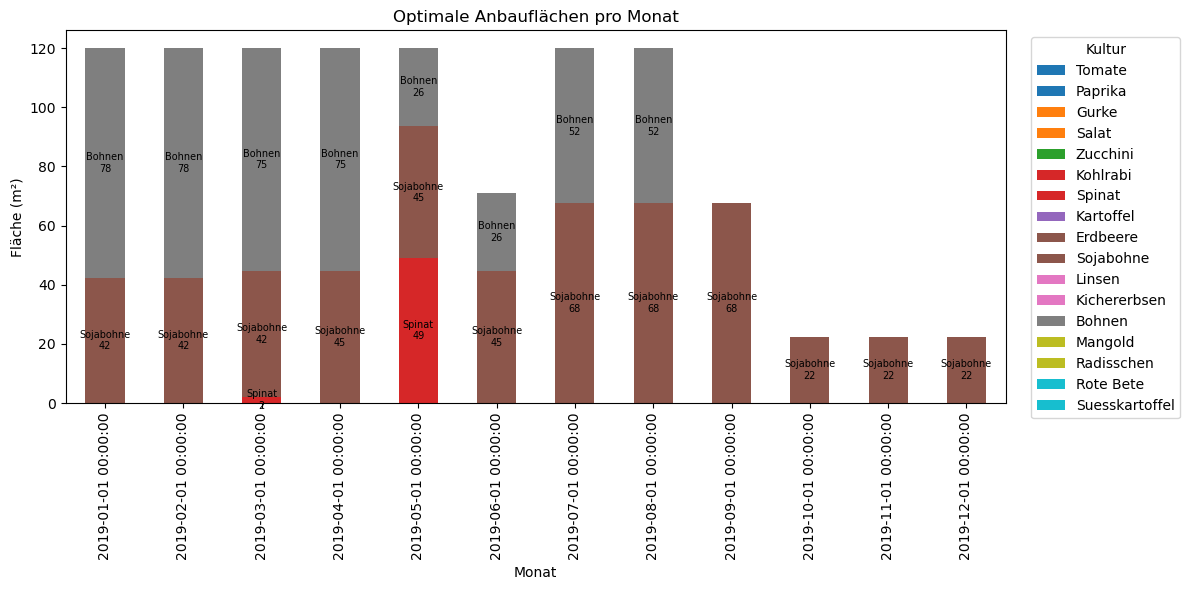

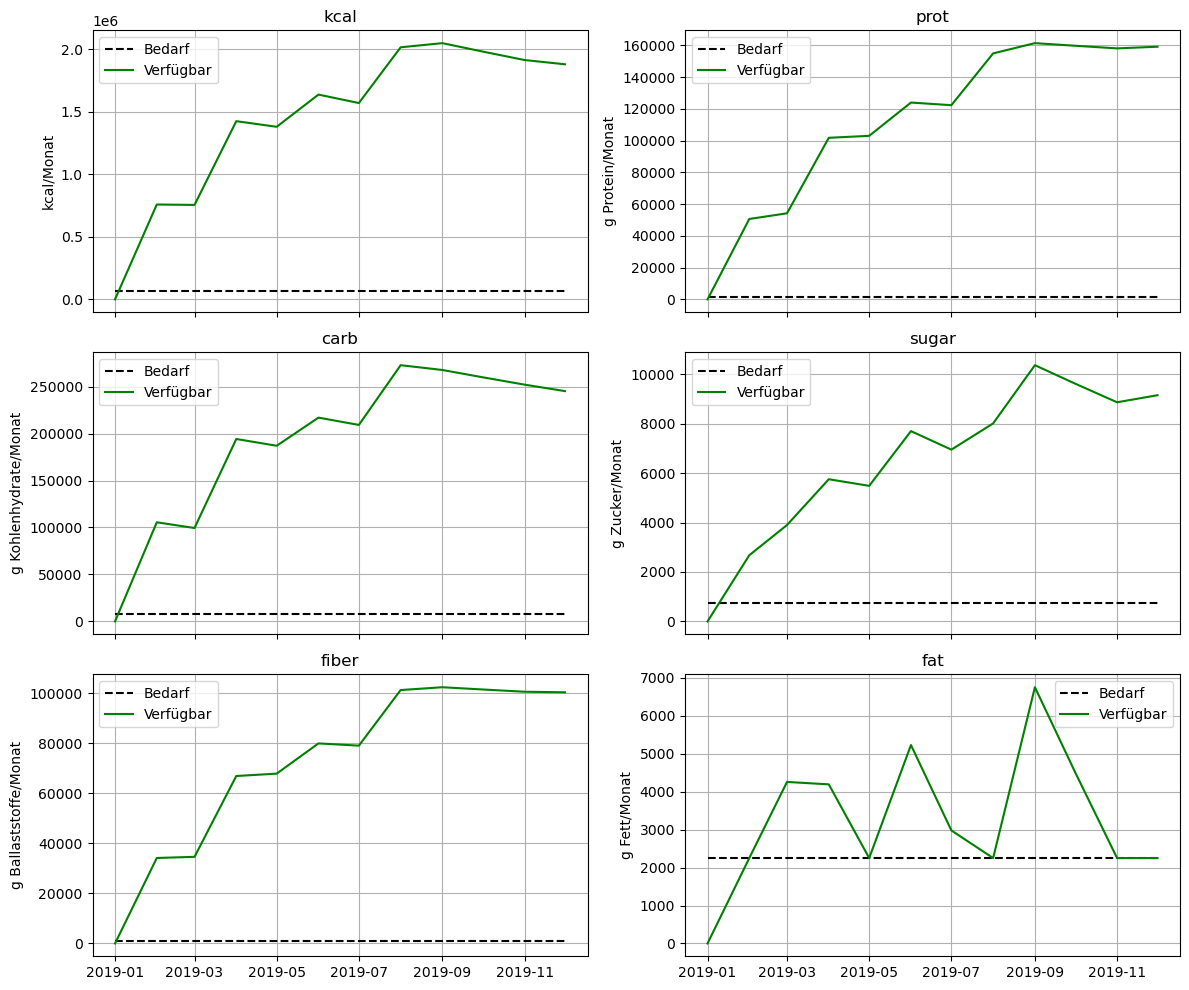

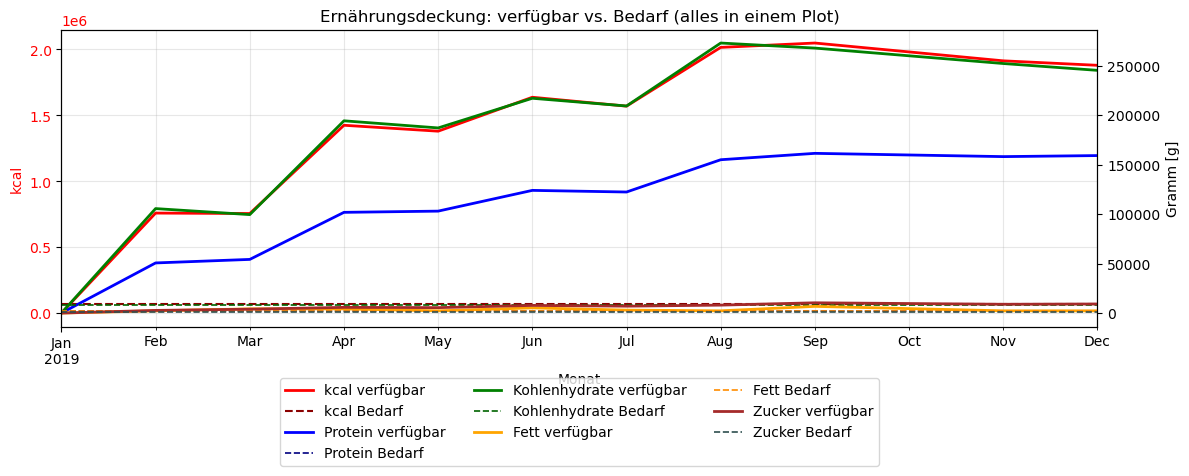

In [42]:

# (A) Gelöste Variablen
area_opt  = m.variables["area"].solution         # (snapshot, crop) in m²
build_opt = m.variables["build"].solution        # (crop) ∈ {0,1}

# (B) Abgeleitete Indikatoren
built_from_area = (area_opt.sum("snapshot") > 1e-6).to_pandas().astype(int)  # 0/1
area_year       = area_opt.sum("snapshot").to_pandas()                        # m²·Monat

# (C) Jahresenergie je Kultur
energy_year_by_crop = (area_opt * energy_kwh_per_m2_month).sum(["snapshot", "crop"])
energy_intensity_a  = (energy_kwh_per_m2_month * 12).to_pandas()

# (D) Minimal notwendige Gewächshausfläche (Spitzenbelegung)
df_area = area_opt.to_pandas()
max_used_area = df_area.sum(axis=1).max()
print(f"\n[Key Metric] Maximal gleichzeitig genutzte Fläche: {max_used_area:.1f} m²")

# (E) Zusammenfassung der gebauten Kulturen
df_summary = (
    pd.DataFrame({
        "gebaut": built_from_area,
        "Jahresfläche [m²·Monat]": area_year,
        "Energie-Intensität [kWh/(m²·a)]": energy_intensity_a.reindex(area_year.index),
        "Jahresenergie [kWh/a]": energy_year_by_crop
    })
    .query("gebaut == 1")
    .sort_values("Jahresenergie [kWh/a]", ascending=False)
    .round(1)
)

print("\n[Übersicht] Gebaute Kulturen (sortiert nach Jahresenergie):")
print(df_summary)

# (F) Nur Namen der gebauten Kulturen
grown_crops = df_summary.index.tolist()
print("\nAngebaut werden:", ", ".join(grown_crops) if grown_crops else "keine")

# (G) Monate mit Fläche > 0
def months_active(da):
    s = da.to_pandas() > 1e-6
    return ", ".join(s.index[s].strftime("%b"))

print("\nMonate je Kultur (falls gebaut):")
for crop in grown_crops:
    print(f"- {crop}: {months_active(area_opt.sel(crop=crop))}")


# =====================================================
# 9) Produktion + Verfügbarkeit berechnen
# =====================================================
harvest_sol = yield_per_area * area_opt   # kg

prod_kcal_sol  = (harvest_sol * kcal_per_kg ).sum("crop")
prod_prot_sol  = (harvest_sol * prot_per_kg ).sum("crop")
prod_carb_sol  = (harvest_sol * carb_per_kg ).sum("crop")
prod_sugar_sol = (harvest_sol * sugar_per_kg).sum("crop")
prod_fiber_sol = (harvest_sol * fiber_per_kg).sum("crop")
prod_fat_sol   = (harvest_sol * fat_per_kg  ).sum("crop")

def available_this_month(stock_sol, prod_sol):
    stock_prev = stock_sol.shift(snapshot=1, fill_value=0)
    return stock_prev + prod_sol

avail = {
    "kcal":  available_this_month(m.variables["stock_kcal"].solution,  prod_kcal_sol),
    "prot":  available_this_month(m.variables["stock_prot"].solution,  prod_prot_sol),
    "carb":  available_this_month(m.variables["stock_carb"].solution,  prod_carb_sol),
    "sugar": available_this_month(m.variables["stock_sugar"].solution, prod_sugar_sol),
    "fiber": available_this_month(m.variables["stock_fiber"].solution, prod_fiber_sol),
    "fat":   available_this_month(m.variables["stock_fat"].solution,   prod_fat_sol),
}


# =====================================================
# 10) Plots – Gruppe A: Anbauart und optimale Fläche pro Monat (Stacked Bar)
# =====================================================
ax = df_area.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab10")
plt.title("Optimale Anbauflächen pro Monat")
plt.ylabel("Fläche (m²)")
plt.xlabel("Monat")

# Legende rechts außerhalb
plt.legend(title="Kultur", labels=crops, bbox_to_anchor=(1.02, 1), loc="upper left")

# Beschriftung in die Balken (Crop + Fläche)
for container, crop in zip(ax.containers, crops):
    labels = [f"{crop}\n{w:.0f}" if w > 0 else "" for w in container.datavalues]
    ax.bar_label(container, labels=labels, label_type="center", fontsize=7, color="black")

plt.tight_layout()
plt.show()

# =====================================================
# 11) Plots – Gruppe B: Nährstoffe (Bedarf vs. verfügbar)
# =====================================================
fig, axs = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
axs = axs.ravel()

nutrients = [
    ("kcal",  demand_kcal,  "kcal/Monat"),
    ("prot",  demand_prot,  "g Protein/Monat"),
    ("carb",  demand_carb,  "g Kohlenhydrate/Monat"),
    ("sugar", demand_sugar, "g Zucker/Monat"),
    ("fiber", demand_fiber, "g Ballaststoffe/Monat"),
    ("fat",   demand_fat,   "g Fett/Monat"),
]

for ax, (key, demand_series, ylabel) in zip(axs, nutrients):
    ax.plot(demand_series.snapshot, demand_series, "k--", label="Bedarf")
    ax.plot(demand_series.snapshot, avail[key], "g-", label="Verfügbar")
    ax.set_title(key)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

# =====================================================
# 12) Lager: Alles-in-einem-Plot: kcal links, Prot/Carb/Fat rechts
# =====================================================

def monthly_available(stock_sol: xr.DataArray, prod_sol: xr.DataArray) -> xr.DataArray:
    stock_prev = stock_sol.shift(snapshot=1, fill_value=0)
    return (stock_prev + prod_sol).rename(stock_sol.name.replace("stock_", "avail_"))

# Verfügbar-Bilanzen aus den gelösten Variablen
stocks_opt = {k: m.variables[k].solution for k in
              ["stock_kcal","stock_prot","stock_carb","stock_sugar","stock_fiber","stock_fat"]}

avail_kcal = monthly_available(stocks_opt["stock_kcal"],  prod_kcal_sol)
avail_prot = monthly_available(stocks_opt["stock_prot"],  prod_prot_sol)
avail_carb = monthly_available(stocks_opt["stock_carb"],  prod_carb_sol)
avail_fat  = monthly_available(stocks_opt["stock_fat"],   prod_fat_sol)
avail_sugar = monthly_available(stocks_opt["stock_sugar"], prod_sugar_sol)

# Ein Diagramm mit Zwillingsachse
fig, ax1 = plt.subplots(figsize=(12,5))

# Linke Y-Achse: kcal
avail_kcal.to_pandas().plot(ax=ax1, lw=2, color="red", label="kcal verfügbar")
demand_kcal.to_pandas().plot(ax=ax1, style="--", lw=1.5, color="darkred", label="kcal Bedarf")
ax1.set_ylabel("kcal", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Rechte Y-Achse: Makros in g
ax2 = ax1.twinx()

# Protein (blau)
avail_prot.to_pandas().plot(ax=ax2, lw=2, color="blue", label="Protein verfügbar")
demand_prot.to_pandas().plot(ax=ax2, style="--", lw=1.2, color="navy", label="Protein Bedarf")

# Kohlenhydrate (grün)
avail_carb.to_pandas().plot(ax=ax2, lw=2, color="green", label="Kohlenhydrate verfügbar")
demand_carb.to_pandas().plot(ax=ax2, style="--", lw=1.2, color="darkgreen", label="Kohlenhydrate Bedarf")

# Fett (orange)
avail_fat.to_pandas().plot(ax=ax2, lw=2, color="orange", label="Fett verfügbar")
demand_fat.to_pandas().plot(ax=ax2, style="--", lw=1.2, color="darkorange", label="Fett Bedarf")

# Sugar (braun)
avail_sugar.to_pandas().plot(ax=ax2, lw=2, color="brown", label="Zucker verfügbar")
demand_sugar.to_pandas().plot(ax=ax2, style="--", lw=1.2, color="darkslategray", label="Zucker Bedarf")

ax2.set_ylabel("Gramm [g]")

# Titel, Gitter, Legende außen
ax1.set_title("Ernährungsdeckung: verfügbar vs. Bedarf (alles in einem Plot)")
ax1.set_xlabel("Monat")
ax1.grid(True, which="both", axis="both", alpha=0.3)

# Legende zusammenführen
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.tight_layout()
plt.show()


In [43]:
#Profile für Licht & Wasser der angebauten Pflanzen

In [44]:
# Monatszuordnung/Hilfsfunktionen
snapshots_m = n.snapshots              # Monatsanfang (MS)
snapshots_h = pd.date_range("2019-01-01", periods=8760, freq="h")

# Kalendertage je Monat (korrekt, statt pauschal 30)
days_in_month = snapshots_m.to_series().dt.days_in_month
on_hours_month  = 16 * days_in_month

# Ergebnis aus der Optimierung (xarray, dims=["snapshot","crop"])
area_opt  = m.variables["area"].solution  # m²

# (1) Monatsfläche dieser Kultur als Pandas-Serie (Index = Monatsanfänge)
a_mon = area_opt.to_pandas()                  # m² @ Monatsinde

# (2) Auf Stunden-Index anheben: zwischen Monatsanfängen mit ffill konstant halten
a_h = a_mon.reindex(snapshots_h, method="ffill")              # m² @ Stundenindex


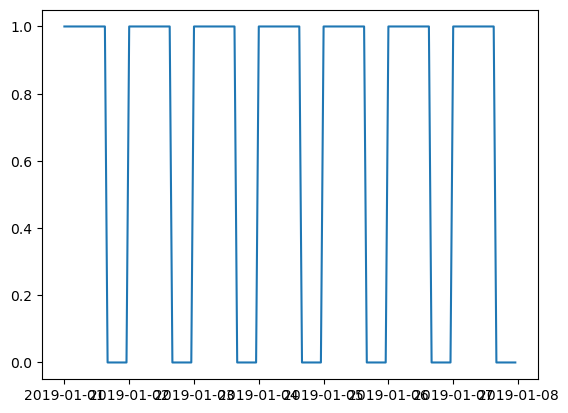

In [45]:
# 16h an / 8h aus als Vektor (0=aus, 1=an)
def light_profile_16on_8off(snapshots_h):
    hours_of_day = np.arange(len(snapshots_h)) % 24     # 0,1,2,...,23,0,1,2,...
    on = (hours_of_day < 16).astype(float)          # 0..15 -> 1 (an), 16..23 -> 0 (aus)
    return pd.Series(on, index=snapshots_h, name="light_on")

light_on = light_profile_16on_8off(snapshots_h)

#(optional) Sichtprüfung: nur den ersten Tag plotten
first_day = light_on.loc["2019-01-01":"2019-01-07 23:00"]
plt.plot(first_day)
plt.show()

In [46]:
profiles_light = {}

In [47]:
for crop in crops:
    # 1) Monats-Energie je m² aus Excel
    need_kwh_per_m2_month = float(df_crops_parameter.loc[crop, "light_kwh_per_m2_month"])

    # 2) kW/m² während 'an' -> pro Monat: (kWh/m²/Monat) / (ON-Stunden im Monat)
    P_on_mon = (need_kwh_per_m2_month / on_hours_month).rename("kW_per_m2_when_on")  # Index=MS

    # 3) auf Stunden heben und mit Schalter & Fläche multiplizieren
    P_on_h   = P_on_mon.reindex(snapshots_h, method="ffill")                          # kW/m² stündlich (nur Skalierung)
    prof_kW  = P_on_h * light_on * a_h[crop]                                          # kW = (kW/m²)*(-)*m²

    profiles_light[crop] = prof_kW


In [48]:
# Monatliche kWh aus Stundenprofil
E_from_hours = pd.Series({m: profiles_light[crop].loc[str(m.date())].sum()
                          for m in snapshots_m})           # kWh/Monat je m (weil kW * 1h summiert)
# Sollwert: (kWh/m²/Monat) * (Monatsfläche)
E_target = a_mon[crop] * need_kwh_per_m2_month
print("max. Abweichung [kWh]:", (E_from_hours - E_target).abs().max())


max. Abweichung [kWh]: 0.0


In [49]:
# Wasserprofil Funktion


In [50]:
profiles_water = {}

In [51]:
def water_profile(T_days, W_max, index_h, start_hour=0):
    """
    Parabolisches Profil über T_days.
    W_max: L/(m²·Tag); Rückgabe: L/(m²·h) auf Stundenindex.
    """
    T_h = int(round(float(T_days)*24))
    if T_h <= 0 or W_max < 0:
        return pd.Series(0.0, index=index_h)

    hours = np.arange(len(index_h))
    tau   = (hours - int(start_hour)) % T_h
    t_d   = tau / 24.0

    core = 1.0 - ((t_d - T_days/2)/(T_days/2))**2          # 0 an Rand, 1 in Mitte
    core = np.clip(core, 0.0, None)

    return pd.Series((W_max*core)/24.0, index=index_h)      # L/(m²·h)

profiles_water = {}  # je crop: stündliche L/h

for crop in crops:
    p = df_crops_parameter.loc[crop]
    w_unit_Lpm2h = water_profile(T_days=p["T_days"],
                                 W_max=p["W_max"],
                                 index_h=snapshots_h,
                                 start_hour=0)              # L/(m²·h)
    profiles_water[crop] = w_unit_Lpm2h * a_h[crop]        # L/h


In [52]:
total_light_kWh  = pd.DataFrame(profiles_light).sum(axis=1)   # kW gesamt
total_water_Lph = pd.DataFrame(profiles_water).sum(axis=1)   # L/h gesamt


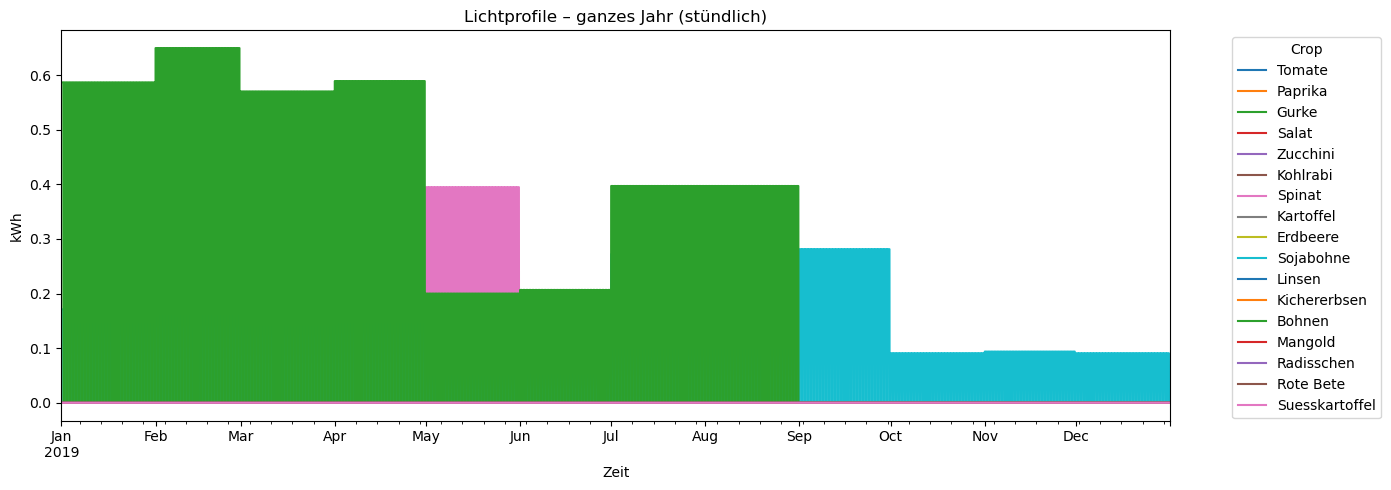

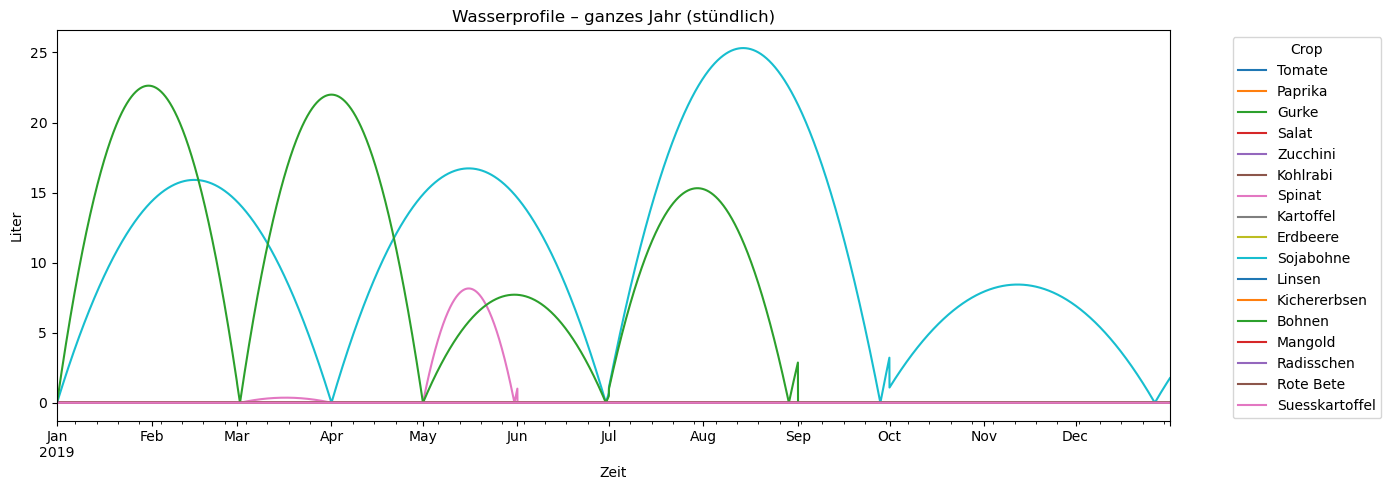

In [53]:
# === Plot Licht-Profile (ganzes Jahr, stündlich) ===
pd.DataFrame(profiles_light).plot(figsize=(14,5))
plt.title("Lichtprofile – ganzes Jahr (stündlich)")
plt.xlabel("Zeit")
plt.ylabel("kWh")
plt.legend(title="Crop", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# === Plot Wasser-Profile (ganzes Jahr, stündlich) ===
pd.DataFrame(profiles_water).plot(figsize=(14,5))
plt.title("Wasserprofile – ganzes Jahr (stündlich)")
plt.xlabel("Zeit")
plt.ylabel("Liter")
plt.legend(title="Crop", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


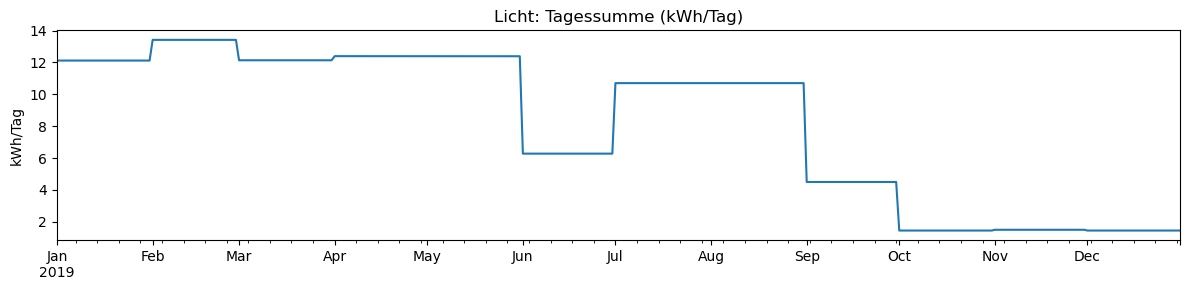

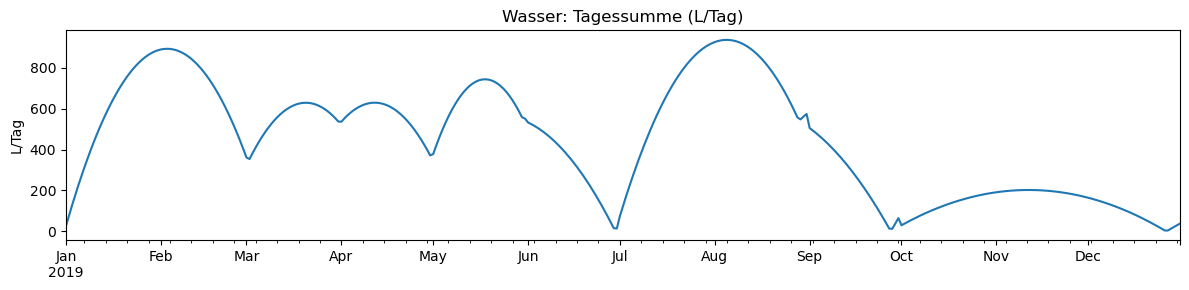

In [54]:
# Tages- und Monatssummen
total_light_kWh_day  = total_light_kWh.resample("D").sum()       # kWh/Tag
total_water_L_day    = total_water_Lph.resample("D").sum()      # Liter/Tag

total_light_kWh_mon  = total_light_kWh.resample("MS").sum()      # kWh/Monat
total_water_L_mon    = total_water_Lph.resample("MS").sum()     # Liter/Monat

# Schneller Check-Plot (optional)
ax = total_light_kWh_day.plot(figsize=(12,3), title="Licht: Tagessumme (kWh/Tag)")
ax.set_ylabel("kWh/Tag"); plt.tight_layout(); plt.show()

ax = total_water_L_day.plot(figsize=(12,3), title="Wasser: Tagessumme (L/Tag)")
ax.set_ylabel("L/Tag"); plt.tight_layout(); plt.show()




In [55]:
# Wasserprofil anpassen auf W/h

In [56]:
# Aus dem Datenblatt (h=3m, n = 15%)
Faktor_water_to_W = 0.0545
Faktor_water_to_kW_per_h = Faktor_water_to_W / 1000

# Wasserlastprofil umstellen
total_water_kW_per_h = total_water_Lph * Faktor_water_to_kW_per_h

load_profiles = pd.DataFrame({
    "light_kW": total_light_kWh,
    "water_L_per_h": total_water_Lph,
    "water_kW": total_water_kW_per_h
})

# Als CSV speichern:
# load_profiles.to_csv("../Input/szenario_load_profiles/load_profiles_hourly_final.csv", index_label="timestamp")

print("CSV exportiert: load_profiles_hourly_final.csv")

CSV exportiert: load_profiles_hourly_final.csv


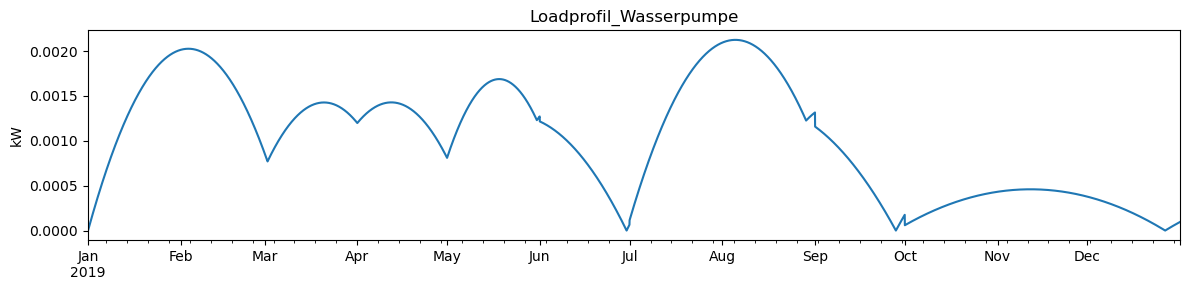

In [57]:
ax = total_water_kW_per_h.plot(figsize=(12,3), title="Loadprofil_Wasserpumpe")
ax.set_ylabel("kW")
plt.tight_layout()
plt.show()


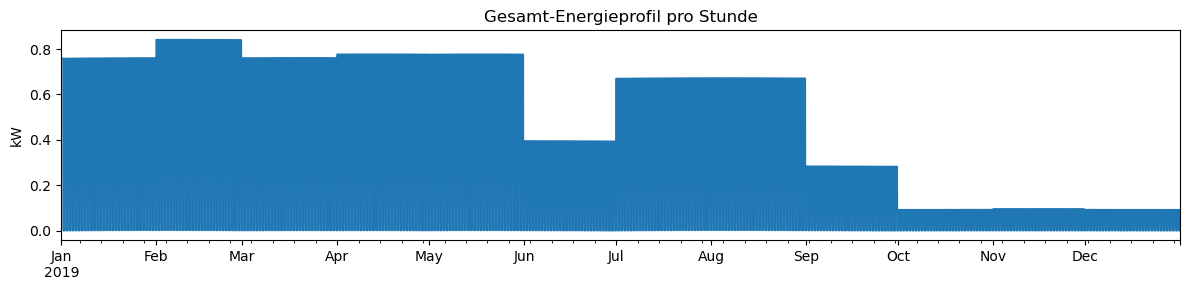

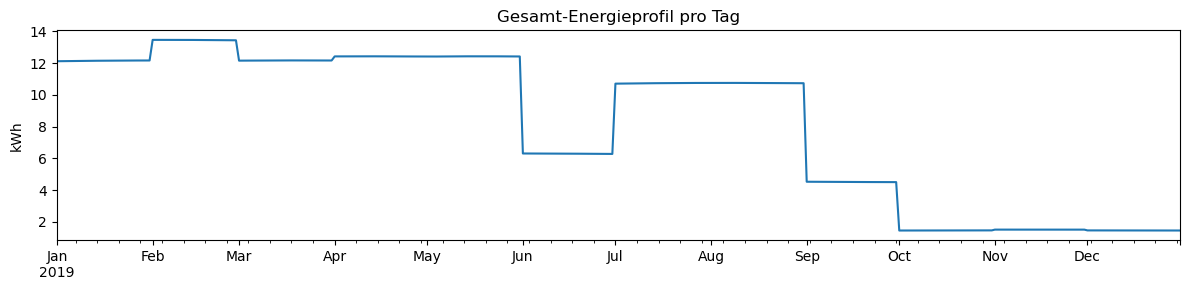

In [58]:
# Gesamtenergie loadprofile

total_energy_kWh = total_light_kWh + total_water_kW_per_h
total_energy_kWh_day  = total_energy_kWh.resample("D").sum()

# Plot

ax = total_energy_kWh.plot(figsize=(12,3), title="Gesamt-Energieprofil pro Stunde")
ax.set_ylabel("kW")
plt.tight_layout()
plt.show()

# # Plotten nur einer Woche
# ax = total_energy_kWh.loc["2019-01-01":"2019-01-07"].plot(
#     figsize=(12,3),
#     title="Gesamt-Energieprofil – erste Woche"
# )
# ax.set_ylabel("kWh")
# plt.tight_layout()
# plt.show()

ax = total_energy_kWh_day.plot(figsize=(12,3), title="Gesamt-Energieprofil pro Tag")
ax.set_ylabel("kWh")
plt.tight_layout()
plt.show()






In [59]:
#Gesamtenergie im Jahr


In [60]:
total_energy_year_kwh = total_energy_kWh.sum()

print(total_energy_year_kwh)

3015.11730998687


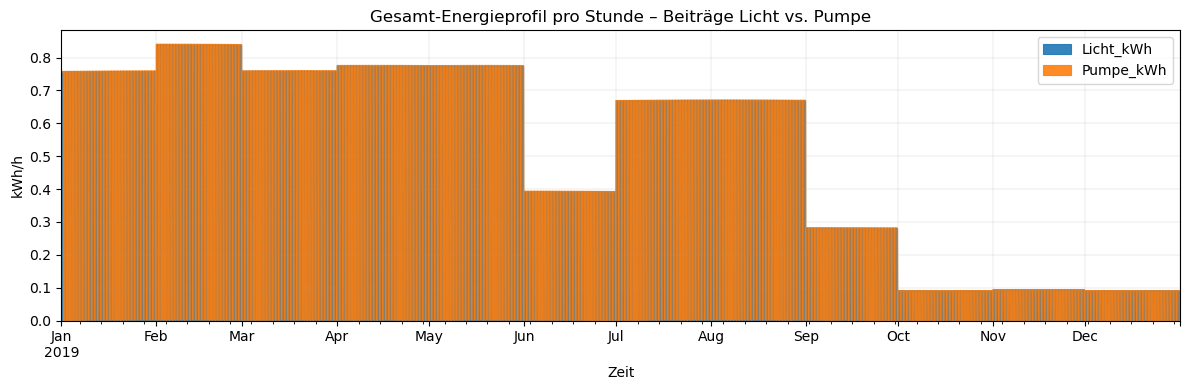

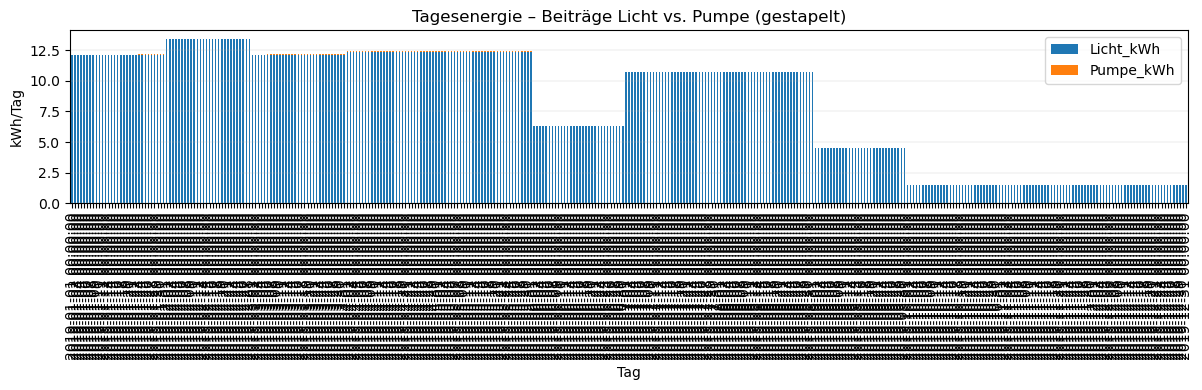

Jahresenergie Licht: 3006.13 kWh
Jahresenergie Pumpe: 8.99 kWh
Jahresenergie gesamt: 3015.12 kWh


In [61]:
# Gesamtprofil (kWh pro Stunde):
total_energy_kWh = total_light_kWh + total_water_kW_per_h

# =========================
# 2) Gestapelte Flächendarstellung (stündlich)
# =========================
df_hour = pd.DataFrame({
    "Licht_kWh": total_light_kWh,
    "Pumpe_kWh": total_water_kW_per_h
})

ax = df_hour.plot.area(figsize=(12,4), linewidth=0.8, alpha=0.9,
                       title="Gesamt-Energieprofil pro Stunde – Beiträge Licht vs. Pumpe")
ax.set_ylabel("kWh/h")
ax.set_xlabel("Zeit")
ax.grid(True, linewidth=0.3, alpha=0.6)
plt.tight_layout()
plt.show()

# Optional: auf eine Woche zoomen (ohne Extra-Variable):
# df_hour.loc["2019-01-01":"2019-01-07"].plot.area(...)

# =========================
# 3) Gestapelte Balken (tägliche Summen)
# =========================
df_day = df_hour.resample("D").sum()

ax = df_day.plot(kind="bar", stacked=True, figsize=(12,4),
                 title="Tagesenergie – Beiträge Licht vs. Pumpe (gestapelt)")
ax.set_ylabel("kWh/Tag")
ax.set_xlabel("Tag")
ax.grid(True, axis="y", linewidth=0.3, alpha=0.6)
plt.tight_layout()
plt.show()

# =========================
# 4) Kontrolle: Jahressummen
# =========================
jahr_sum_licht = df_hour["Licht_kWh"].sum()
jahr_sum_pumpe = df_hour["Pumpe_kWh"].sum()
jahr_sum_total = total_energy_kWh.sum()
print(f"Jahresenergie Licht: {jahr_sum_licht:.2f} kWh")
print(f"Jahresenergie Pumpe: {jahr_sum_pumpe:.2f} kWh")
print(f"Jahresenergie gesamt: {jahr_sum_total:.2f} kWh")
